In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
from scipy.optimize import curve_fit
import matplotlib as mpl
from glob import glob
from copy import copy

%matplotlib widget

In [2]:
freqs, s21 = np.load('./S21_dark.npy')

400


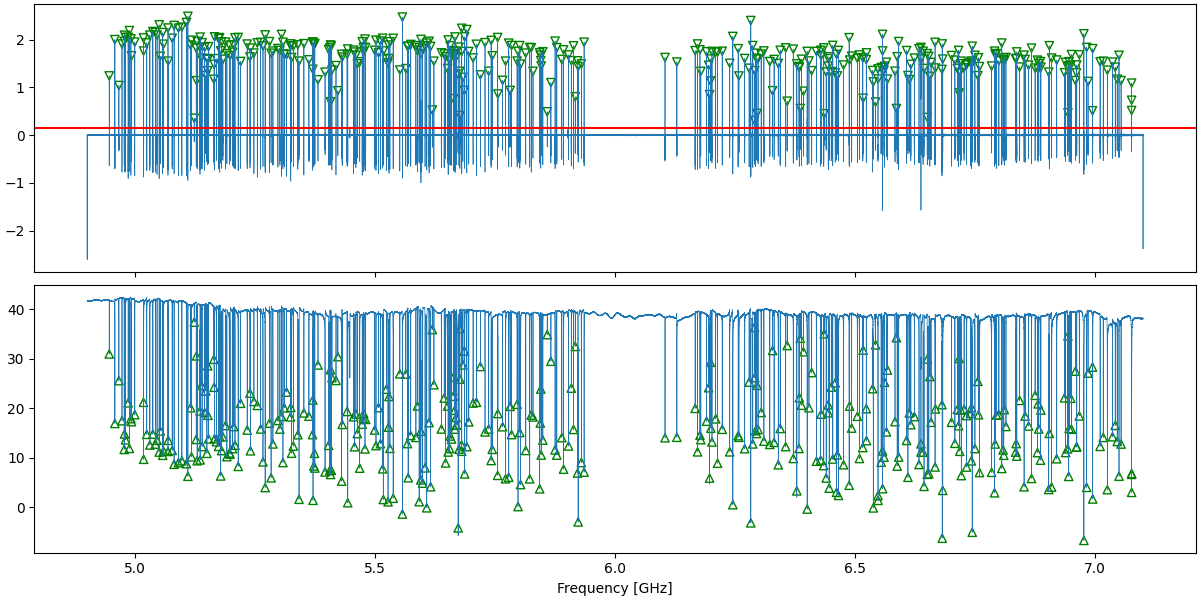

In [3]:
sw = 4 # even number
mph = 0.15
window = np.ones(sw)/sw
smooth_s21 = convolve(s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
# ax['a'].plot(smooth_ds21)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, s21, lw=.5)
ax['a'].axhline(mph, c='r')
# ax['b'].plot(s21)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']
ax['a'].scatter(freqs[:-2][locs], heights, marker='v', c='None', edgecolor='g')
# ax['a'].scatter(freqs[locs[(locs[1:]-locs[:-1]) < 10]], heights, marker='v', c='None', edgecolor='r')
ax['b'].scatter(freqs[locs], s21[locs], marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))



399


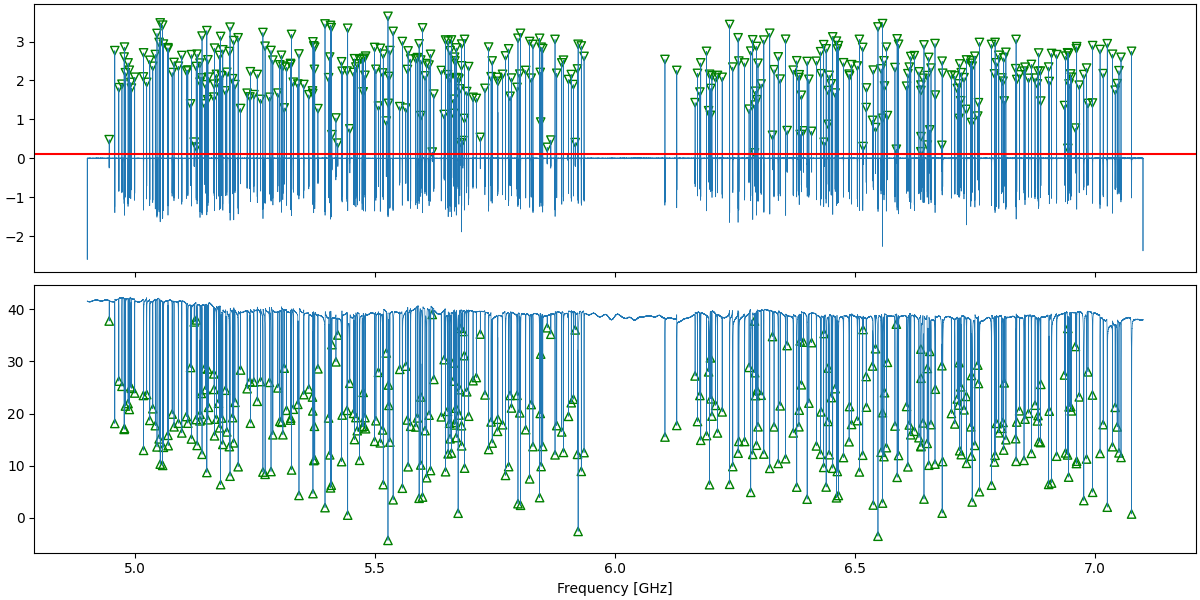

In [4]:
dir = './Mapping_20x20_grounded/'
dark_s21 = np.load(glob(dir + '*dark.npy')[0])
freqs = np.load(glob(dir + '*freqs.npy')[0])
sw = 4 # even number
mph = 0.1
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
# ax['a'].plot(smooth_ds21)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, dark_s21, lw=.5)
ax['a'].axhline(mph, c='r')
# ax['b'].plot(s21)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']
ax['a'].scatter(freqs[:-2][locs], heights, marker='v', c='None', edgecolor='g')
# ax['a'].scatter(freqs[locs[(locs[1:]-locs[:-1]) < 10]], heights, marker='v', c='None', edgecolor='r')
ax['b'].scatter(freqs[locs], dark_s21[locs], marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

In [ ]:
yfiles = glob(dir + '*x0*.npy')
xfiles = glob(dir + '*y0*.npy')
nr_x = len(xfiles)
nr_y = len(yfiles)
nr_steps = int(np.amax((nr_x, nr_y)))
nr_kids = len(locs)
s21s = np.empty((nr_steps, 2, nr_kids))
s21s[:] = np.nan
s0 = dark_s21[locs]
sx0 = np.load(xfiles[0])[locs]
sy0 = np.load(yfiles[0])[locs]
for i, xfile in enumerate(xfiles):
    if i < len(xfiles):
        s21x = np.load(xfile)
        s21s[i, 0, :]  = s21x[locs] - sx0
    if i < len(yfiles):
        yfile = yfiles[i]
        s21y = np.load(yfile)
        s21s[i, 1, :]  = s21y[locs] - sy0 
s21s = s21s[5:-5, :, :]

In [ ]:
sw = 5
dw = 4
medw = 3
mph = .2
mpw = 0
mpp = mph/2
smooth_s21s = np.empty((len(xfiles)+1, 2, len(locs)))
smooth_s21s[:] = np.nan
smooth_d2s21s = np.empty((len(xfiles)+6, 2, len(locs)))
smooth_d2s21s[:] = np.nan
window = np.ones(sw)/sw
dwindow = np.ones(dw)/dw
pos = np.empty((nr_kids, 3))
pos[:] = np.nan
pos[:, 2] = np.arange(nr_kids)
semi_pos = np.empty((nr_kids, 3))
semi_pos[:] = np.nan
semi_pos[:, 2] = np.arange(nr_kids)
nr_good = 0
nr_semi = 0
bad = []
good = []
semi = []
for i in range(nr_kids):
    powerx = s21s[:, 0, i]
    powerx = powerx[~np.isnan(powerx)]
    medpowerx = medfilt(powerx, medw)
    smoothpowerx = convolve(medpowerx, window, mode='valid')
    smooth_s21s[:len(smoothpowerx), 0, i] = smoothpowerx
    d1x = np.diff(smoothpowerx, 1)
    d1xsmooth = convolve(d1x, dwindow, mode='valid')
    d2x = np.diff(d1xsmooth, 1)
    d2x = convolve(d2x, dwindow, mode='valid')
    smooth_d2s21s[:len(d2x), 0, i] = d2x

    powery = s21s[:, 1, i]
    powery = powery[~np.isnan(powery)]
    medpowery = medfilt(powery, medw)
    smoothpowery = convolve(medpowery, window, mode='valid')
    smooth_s21s[:len(smoothpowery), 1, i] = smoothpowery
    d1y = np.diff(smoothpowery, 1)
    d1ysmooth = convolve(d1y, dwindow, mode='valid')
    d2y = np.diff(d1ysmooth, 1)
    d2y = convolve(d2y, dwindow, mode='valid')
    smooth_d2s21s[:len(d2y), 1, i] = d2y
    locx, propx = find_peaks(-d2x, height=mph, prominence=mpp, width=mpw)
    locy, propy = find_peaks(-d2y, height=mph, prominence=mpp, width=mpw)
    
    if len(locx)==1 and len(locy)==1:
        cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)[0]
        cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)[0]
        pos[i, :2] = np.array([cx, cy]).flatten()
        nr_good += 1
        good.append(i)
    elif len(locx)==1 or len(locy)==1:
        if len(locx) == 1:
            cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)[0]
            cy = np.nanargmin(d2y)
        if len(locy) == 1:
            cx = np.nanargmin(d2x)
            cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)[0]
        semi_pos[i, :2] =  np.array([cx, cy]).flatten()   
        nr_semi += 1
        semi.append(i)
    else:
        bad.append(i)
        pass
print('good: ', len(good))
print('semi: ', len(semi))
print('bad: ', len(bad))
kid = semi
fig, ax = plt.subplot_mosaic('ab;cd', figsize=(8, 8))
_ = ax['a'].plot(s21s[:, 0, kid], lw=.5)
_ = ax['b'].plot(s21s[:, 1, kid], lw=.5)
_ = ax['c'].plot(-smooth_d2s21s[:, 0, kid], lw=.5)
_ = ax['d'].plot(-smooth_d2s21s[:, 1, kid], lw=.5)
_ = ax['c'].axhline(mph, c='r')
_ = ax['d'].axhline(mph, c='r')
# d2ysmooth = smooth_d2s21s[:, 1, kid]

In [ ]:
kid = 43
x = s21s[:, 0, kid]
y = s21s[:, 1, kid]
xsmooth = smooth_s21s[:, 0, kid]
ysmooth = smooth_s21s[:, 1, kid]
d2xsmooth = smooth_d2s21s[:, 0, kid]
d2ysmooth = smooth_d2s21s[:, 1, kid]

fig, ax = plt.subplot_mosaic('ab;cd;ef', figsize=(10, 9), sharex=True)
ax['a'].plot(x)
ax['b'].plot(y)

ax['c'].plot(xsmooth)
ax['d'].plot(ysmooth)
ax['c'].scatter(np.nanargmax(xsmooth), np.nanmax(xsmooth), c='r')
ax['d'].scatter(np.nanargmax(ysmooth), np.nanmax(ysmooth), c='r')

ax['e'].plot(d2xsmooth)
ax['f'].plot(d2ysmooth)
ax['e'].axhline(-mph, c='r')
ax['f'].axhline(-mph, c='r')
locx, propx = find_peaks(-d2xsmooth, height=mph, prominence=mpp, width=mpw)
cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)
locy, propy = find_peaks(-d2ysmooth, height=mph, prominence=mpp, width=mpw)
cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)
ax['e'].scatter(locx, -propx['peak_heights'], c='r')
ax['f'].scatter(locy, -propy['peak_heights'], c='r')
ax['e'].set_ylim(-1, 1)
ax['f'].set_ylim(-1, 1)
ax['e'].scatter(cx, -propx['peak_heights'], c='None', edgecolor='g')
ax['f'].scatter(cy, -propy['peak_heights'], c='None', edgecolor='g')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
full_pos = np.empty((nr_kids, 3))
full_pos[:] = np.nan
full_pos[:, 2] = np.arange(nr_kids)
ax.scatter(*np.round(pos[:, :2]).T)
# ax.scatter(*semi_pos[:, :2].T)
gridx = np.array([5, 8, 12, 20, 25, 30])
gridy = np.array([3, 7.5, 10.5, 15, 24, 28])
# for i in range(len(gridx)):
#     ax.axvline(gridx[i], c='k', lw=.5)
#     ax.axhline(gridy[i], c='k', lw=.5)
for coord in pos:
    if ~np.any(np.isnan(coord)):
        text = ax.text(coord[0]+.5, coord[1]+.5, str(int(coord[2])), ha="center", va="center", color="k", fontsize='small',zorder=4)  
# for coord in semi_pos:
#     if ~np.any(np.isnan(coord)):
#         text = ax.text(coord[0]+.5, coord[1]+.5, str(int(coord[2])), ha="center", va="center", color="k", fontsize='small',zorder=4)  
full_pos[:, :2] = pos[:, :2] + semi_pos[:, :2]

In [ ]:
kid_id_board = np.load('KID_id_board_400.npy')
kid_id_board -= 1
kid_id_board = np.flip(kid_id_board, axis=0)
kid_id_board

In [ ]:
kids = np.array([[23, 34, 25, 2, 13, 4], 
                  [14, 3, 15, 32, 21, 26],
                  [19, 30, 9, 0, 11, 6],
                  [10, 7, 18, 31, 20, 29],
                  [35, 24, 1, 8, 5, 12],
                  [27, 16, 33, 17, 28, 22]
                  ])
kids = kids.T
print(kids)
kids = np.flip(kids, 1)
kids

In [ ]:
M_pxs = 6
N_pxs = 6
mask = (kids == kid_id_board)
nr_tot = (M_pxs*N_pxs)
nr_detected = nr_kids
nr_notswapped = np.sum(mask)
nr_identified = np.sum(~np.isnan(kids))
nr_swapped = nr_identified - nr_notswapped
same = np.argwhere(mask)
ids = np.rint(np.linspace(0, 399, M_pxs*N_pxs)).astype(int)
f0s_design = np.load('LEKID_EBEAM_f0s_5-7GHz.npy')[ids]
f0s = freqs[locs]*1e9
f0s_mapped = np.empty(f0s_design.shape)
f0s_mapped[:] = np.nan
df_f = np.empty(kids.shape)
df_f[:] = np.nan
df = np.empty(kids.shape)
df[:] = np.nan
mapped_spacings = np.empty(kids.shape)
mapped_spacings[:] = np.nan
for i in range(M_pxs):
    for j in range(N_pxs):
        design_kid = kid_id_board[i, j]
        design_f0_idx = design_kid
        design_f0 = f0s_design[design_f0_idx]
        mapped_kid = kids[i, j]
        if ~np.isnan(mapped_kid):
            mapped_f0_idx = mapped_kid
            mapped_f0_idx = int(mapped_f0_idx)
            mapped_f0 = f0s[mapped_f0_idx]
            f0s_mapped[design_kid] = mapped_f0
            df[i, j] = (design_f0 - mapped_f0)
            df_f[i, j] = df[i, j] / design_f0
            if design_kid > 1:
                prev_design_kid = design_kid - 1
                prev_i, prev_j = np.argwhere(kid_id_board==prev_design_kid)[0]
                prev_mapped_kid = kids[prev_i, prev_j]
                if ~np.isnan(prev_mapped_kid):
                    prev_mapped_f0_idx = prev_mapped_kid - 1
                    prev_mapped_f0_idx = int(prev_mapped_f0_idx)
                    prev_mapped_f0 = f0s[prev_mapped_f0_idx]
                    mapped_spacings[i, j] = mapped_f0 - prev_mapped_f0
std_df_f = np.std(df_f[~np.isnan(df_f)])

In [ ]:
std_df_f

In [ ]:
fig, ax = plt.subplot_mosaic('ba', figsize=(12, 6), constrained_layout=True)

############################
ax['a'].imshow(kids, origin='lower', cmap='viridis')
for i in range(M_pxs):
    for j in range(N_pxs):
        idx = kids[i, j]
        if ~np.isnan(idx):
            if mask[i, j]:
                color = 'w'
            else:
                color = 'tab:red'
            text = ax['a'].text(j, i, '%d' % idx, ha="center", va="center", color=color, fontsize='x-small') 
# Major ticks
ax['a'].set_xticks(np.arange(0, M_pxs, 1));
ax['a'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['a'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['a'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['a'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['a'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['a'].set_xlabel('$\it x$ $[px]$')
ax['a'].set_ylabel('$\it y$ $[px]$')
# ax['a'].set_title("Measurement")
# grid
ax['a'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['a'].grid(False, which='major')

############################
im = ax['b'].imshow(kid_id_board, origin='lower', cmap='viridis')
for i in range(M_pxs):
    for j in range(N_pxs):
        idx = kid_id_board[i, j]
        if ~np.isnan(idx):
            text = ax['b'].text(j, i, '%d' % idx, ha="center", va="center", color="w", fontsize='x-small')   
# Major ticks
ax['b'].set_xticks(np.arange(0, M_pxs, 1));
ax['b'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['b'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['b'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['b'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['b'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['b'].set_xlabel('$\it x$ $[px]$')
ax['b'].set_ylabel('$\it y$ $[px]$')
# ax['b'].set_title("Design")
# grid
ax['b'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['b'].grid(False, which='major')
# cbar = fig.colorbar(im, ax=ax['b'])
# # cbar.ax.invert_yaxis()
# cbar.ax.set_ylabel('$f_0$ $[GHz]$')




In [ ]:

fig, ax = plt.subplot_mosaic('hcc;fcc', figsize=(15, 10), constrained_layout=True)

###################################
# ax['h'].hist(spacings*1e-6, bins=50, alpha=.8, label='before')
ax['h'].hist(mapped_spacings.flatten()*1e-6, bins=40, alpha=1, label='after')
# ax['h'].set_xlim([-100, 100])
# ax['h'].set_ylim([0, 50])
ax['h'].set_xlabel('$d\it{f_0}$ $[MHz]$')
ax['h'].set_ylabel('Counts')

###################################
ax['f'].hist((df_f.flatten()*100), bins=15)
ax['f'].text(8, 50, "$\it\sigma_{\delta f_0/f_0}$ = $%.1f \\times 10^{-3}$" % (std_df_f*1e3))
# ax['f'].set_xlim((7, 11))
ax['f'].set_xlabel('$\it \delta f_0/f_0$ [%]')
ax['f'].set_ylabel('Counts')
# ax['f'].set_ylim([0, 60])
ax['f'].set_title("Frequency scatter, $\it\sigma_{df/f}$ = $%.1f x 10^{-3}$" % (std_df_f*1e3))
# ax['f'].legend()
print('# detected: %d/%d\n# identified: %d/%d\n# swapped: %d/%d ' % (nr_detected, nr_tot, nr_identified, nr_detected, nr_swapped, nr_identified))

###################################
im = ax['c'].imshow(df, origin='lower', cmap='viridis')
# for i in range(M_pxs):
#     for j in range(N_pxs):
#         idx = kids[i, j]
#         if ~np.isnan(idx):
#             if mask[i, j]:
#                 color = 'w'
#             else:
#                 color = 'tab:red'
#             text = ax['c'].text(j, i, '%d' % idx, ha="center", va="center", color=color, fontsize='x-small') 
# Major ticks
ax['c'].set_xticks(np.arange(0, M_pxs, 1));
ax['c'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['c'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['c'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['c'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
# ax['c'].set_title("$\it\sigma_{df/f}$ = $%.1f x 10^{-3}$" % (std_df_f*1e3))
# grid
ax['c'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['c'].grid(False, which='major')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it \delta f_0/f_0$ [%]')
# print('Unidentified: \n', newhidden_pks)
# plt.savefig('scatter.svg')

In [ ]:
def linear(x, a):
    return a*x

def secorder(x, a, b, c):
    return a*x**2+b*x

def taylor(fm, fd):
    return (np.sqrt(fm/fd-11/12)-1/np.sqrt(3))/(-np.sqrt(3)/2*(2*np.pi*fd)**2)

ids = np.arange(400)
nans = np.isnan(f0s_mapped)

def lc(f):
    return 1 / (2*np.pi*f)**2

line = linear
popt, pcov = curve_fit(line, f0s_design[~nans], f0s_mapped[~nans])
fit = line(f0s_design, *popt)
corr_df = (f0s_mapped-fit)
dLCs = taylor(f0s_mapped, fit)
LCs = lc(fit)
xfit = np.linspace(0, 9e9, 1000)
yfit = line(xfit, *popt)
corr_df_map = np.empty(kids.shape)
corr_df_map[:] = np.nan
for i, val in enumerate(corr_df):
    x, y = np.argwhere(kid_id_board==i)[0]
    corr_df_map[x, y] = val

fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(f0s_design*1e-9, f0s_design*1e-9, label='$\it f_0^{design}$')
ax['a'].scatter(f0s_design*1e-9, f0s_mapped*1e-9, label='$\it f_0^{meas}$')
ax['a'].plot(xfit*1e-9, xfit*1e-9, c='k', label='$\it y_1=x$')
# ax['a'].plot(xfit*1e-9, yfit*1e-9, c='k', label='fit: $\it y_2=ax^2+bx$', ls='--')
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
flim = [4, 8]
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend()
ax['b'].scatter(f0s_design*1e-9, corr_df*1e-6, label='residual, $f_0-y_2$', color= 'tab:orange')
# ax['b'].plot(xfit*1e-9, (yfit-yfit)*1e-9, c='k', label='$y=0$', ls='--')
ax['b'].set_ylabel('$\it f_0^{meas}-y_2$ $[MHz]$')
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['b'].set_ylim([-60, 50])
ax['b'].set_xlim([4.5, 6.5])
# ax['b'].legend()
# ax['d'].scatter(f0s_design*1e-9, dLCs)
# ax['d'].scatter(f0s_design*1e-9, lc(f0s_mapped)-lc(fit))
# ax['d'].set_ylabel('$\it \delta LC/LC$')
# ax['d'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
# # ax['d'].set_ylim([-60, 50])
# ax['d'].set_xlim([4.5, 6.5])

im = ax['c'].imshow(corr_df_map*1e-6, origin='lower', cmap='viridis', vmin=-60, vmax=50)
# Major ticks
ax['c'].set_xticks(np.arange(0, M_pxs, 1));
ax['c'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['c'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['c'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['c'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
# grid
ax['c'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['c'].grid(False, which='major')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it f_0^{meas}-y_2$ $[MHz]$')
# ax['c'].set_ylim([-100, 50])


In [ ]:
fs = freqs[locs]*1e9
dfs = fs[1:]-fs[:-1]
Q = 5e4
F0 = 6e9
fwhm = F0 / Q
dfwhms = dfs / fwhm
fig, ax = plt.subplots()
_ = ax.hist(dfs*1e-6, bins='auto')
ax.set_xlabel('$df=f^{i+1}_0-f^{i}_0$')
ax.set_ylabel('counts')
ax.set_xlim(0, 50)
# _ = ax.hist(dfwhms, bins='auto')
# ax.set_xlim(0, 500)